In [31]:
# imports
import atracker as atr
import ast
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool
from pybt.trackers.boris import track_to_condition
import warnings
import time
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib notebook

In [32]:
# settings
particle = 'proton'       # particle name: 'proton' or 'carbon12'
en_per_unit_MeV = 26e3    # kinetic energy of the beam
track_end_z_m = 2.5       # approximate location in longitudinal direction of the magnet at where to stop the tracking

# input angle and position of the beam in the global reference system
# values base on discussion with M. Fraser and https://codimd.web.cern.ch/05LpRgDIRIKUpRnTWTfbEA
ang_glob = (0.0682, 0.0)
pos_glob = (6.490e-02,  0.0, -2.51e+00)

read_fm = True            # read out the field map
interpolate_fm = True     # prepare the interpolated field map for tracking
fm_path = '/eos/project-b/beam-transfer-physics/public/data/ps-main-unit-type-u/maps/' # path to the field map file
fm_file = 'MUU_xy_grid.table'
save_ref_traj = False     # save the reference trajectory to a file

# labels for parameters of the 6x6 transport matrix
var_labels = {
    "x": " x [m]",
    "y": " y [m]",
    "xp": " xp [rad]",
    "yp": " yp [rad]",
    "t": " T [m]",
    "D": " D [1]",
} 

if read_fm:
    try:
        df = pd.read_csv(fm_path+fm_file,delim_whitespace=True, skiprows=8, names=['x', 'y', 'z', 'Bx', 'By', 'Bz'])
    except:
        df = pd.read_csv("/mnt/c/Users/Eliott Johnson/cernbox/SWAN_projects/PS stray tracking test/"+fm_file,delim_whitespace=True, skiprows=8, names=['x', 'y', 'z', 'Bx', 'By', 'Bz'])
    # mirroring the field map (wrt y=0) as only half of the magnet field is in the file
    df_mir = df.copy() #copies a list instead of pointing to the same list
    df_mir[["y", "Bx", "Bz"]] = df_mir[["y", "Bx", "Bz"]].apply(np.negative) #multiply by minus 1 the y, Bx and Bz columns
    df_mir = df_mir.drop(df_mir[df_mir['y']==0.0].index) #.drop only select a smaller part of the data frame. Not sure what what the inner part selects

    fieldmap = pd.concat([df, df_mir]) # concatenate joins the two dataframes one after the other

    fieldmap.sort_values(by=['x','y'], inplace=True) #Sorts first the x column and then the y one. See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    fieldmap['Bmod'] = np.sqrt(fieldmap['Bx']**2+fieldmap['By']**2+fieldmap['Bz']**2) #Modulus of the B field. Calulates the length of the vector field and adds it into a additional column
    for axis in ['x', 'y', 'z']: #Loops through these three columns 
        axis_val = fieldmap[axis].unique() #List containing the unique values of each column
        print('In the direction {:} we have {:} values from {:} to {:} in steps of {:}'.format(axis, len(axis_val), axis_val.min(), axis_val.max(), np.unique(np.diff(axis_val)).mean().round(6)))
        #.diff calculates the a[i+1] - a[i]. Basically outputs the steps
        # then you take the mean of the unique steps and round to 6 figures after the decimal
        
    print('And average fields are')    
    print(fieldmap[['Bx', 'By', 'Bz']].mean())    #The syntax is you take the mean of each element in the list

if interpolate_fm:
    interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

In the direction x we have 201 values from -0.76 to 0.76 in steps of 0.0076
In the direction y we have 201 values from -0.9 to 0.9 in steps of 0.009
In the direction z we have 527 values from -2.63 to 2.63 in steps of 0.01
And average fields are
Bx    8.162681e-19
By   -3.424371e-04
Bz    4.846168e-21
dtype: float64


In [33]:
print(fieldmap)

             x    y     z        Bx        By        Bz      Bmod
0        -0.76 -0.9 -2.63  0.000826  0.000737  0.000897  0.001425
1        -0.76 -0.9 -2.62  0.000840  0.000749  0.000901  0.001442
2        -0.76 -0.9 -2.61  0.000854  0.000761  0.000906  0.001459
3        -0.76 -0.9 -2.60  0.000867  0.000772  0.000910  0.001476
4        -0.76 -0.9 -2.59  0.000881  0.000784  0.000915  0.001493
...        ...  ...   ...       ...       ...       ...       ...
21291322  0.76  0.9  2.59  0.000807  0.000634  0.000730  0.001260
21291323  0.76  0.9  2.60  0.000797  0.000627  0.000727  0.001248
21291324  0.76  0.9  2.61  0.000787  0.000620  0.000724  0.001236
21291325  0.76  0.9  2.62  0.000776  0.000613  0.000722  0.001225
21291326  0.76  0.9  2.63  0.000766  0.000607  0.000719  0.001213

[21291327 rows x 7 columns]


In [34]:
print(type(fieldmap))

<class 'pandas.core.frame.DataFrame'>


In [35]:
print(fieldmap["x"])

0          -0.76
1          -0.76
2          -0.76
3          -0.76
4          -0.76
            ... 
21291322    0.76
21291323    0.76
21291324    0.76
21291325    0.76
21291326    0.76
Name: x, Length: 21291327, dtype: float64


In [36]:
#fieldmapsmall = fieldmap.head(10000)
fieldmapsmall = fieldmap.iloc[::10000, :] #Takes one in n rows
print(fieldmapsmall)

             x      y     z        Bx        By        Bz      Bmod
0        -0.76 -0.900 -2.63  0.000826  0.000737  0.000897  0.001425
10000    -0.76 -0.738  2.51  0.001111  0.000653 -0.001156  0.001731
20000    -0.76 -0.567  2.38  0.001494  0.000522 -0.001675  0.002304
30000    -0.76 -0.396  2.25  0.002311 -0.000813 -0.002901  0.003797
40000    -0.76 -0.225  2.12 -0.016487 -1.551850 -0.010994  1.551976
...        ...    ...   ...       ...       ...       ...       ...
21250000  0.76  0.198  0.43 -0.000800 -0.001398  0.000119  0.001615
21260000  0.76  0.369  0.30  0.000308 -0.001587  0.000233  0.001633
21270000  0.76  0.540  0.17  0.000591 -0.000549  0.000231  0.000839
21280000  0.76  0.711  0.04  0.000579  0.000394  0.000172  0.000721
21290000  0.76  0.882 -0.09  0.000536  0.000768  0.000118  0.000944

[2130 rows x 7 columns]


In [37]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
colors = np.arctan2(fieldmapsmall["Bx"], fieldmapsmall["By"])
norm = Normalize()
norm.autoscale(colors)
colormap = cm.inferno

<IPython.core.display.Javascript object>


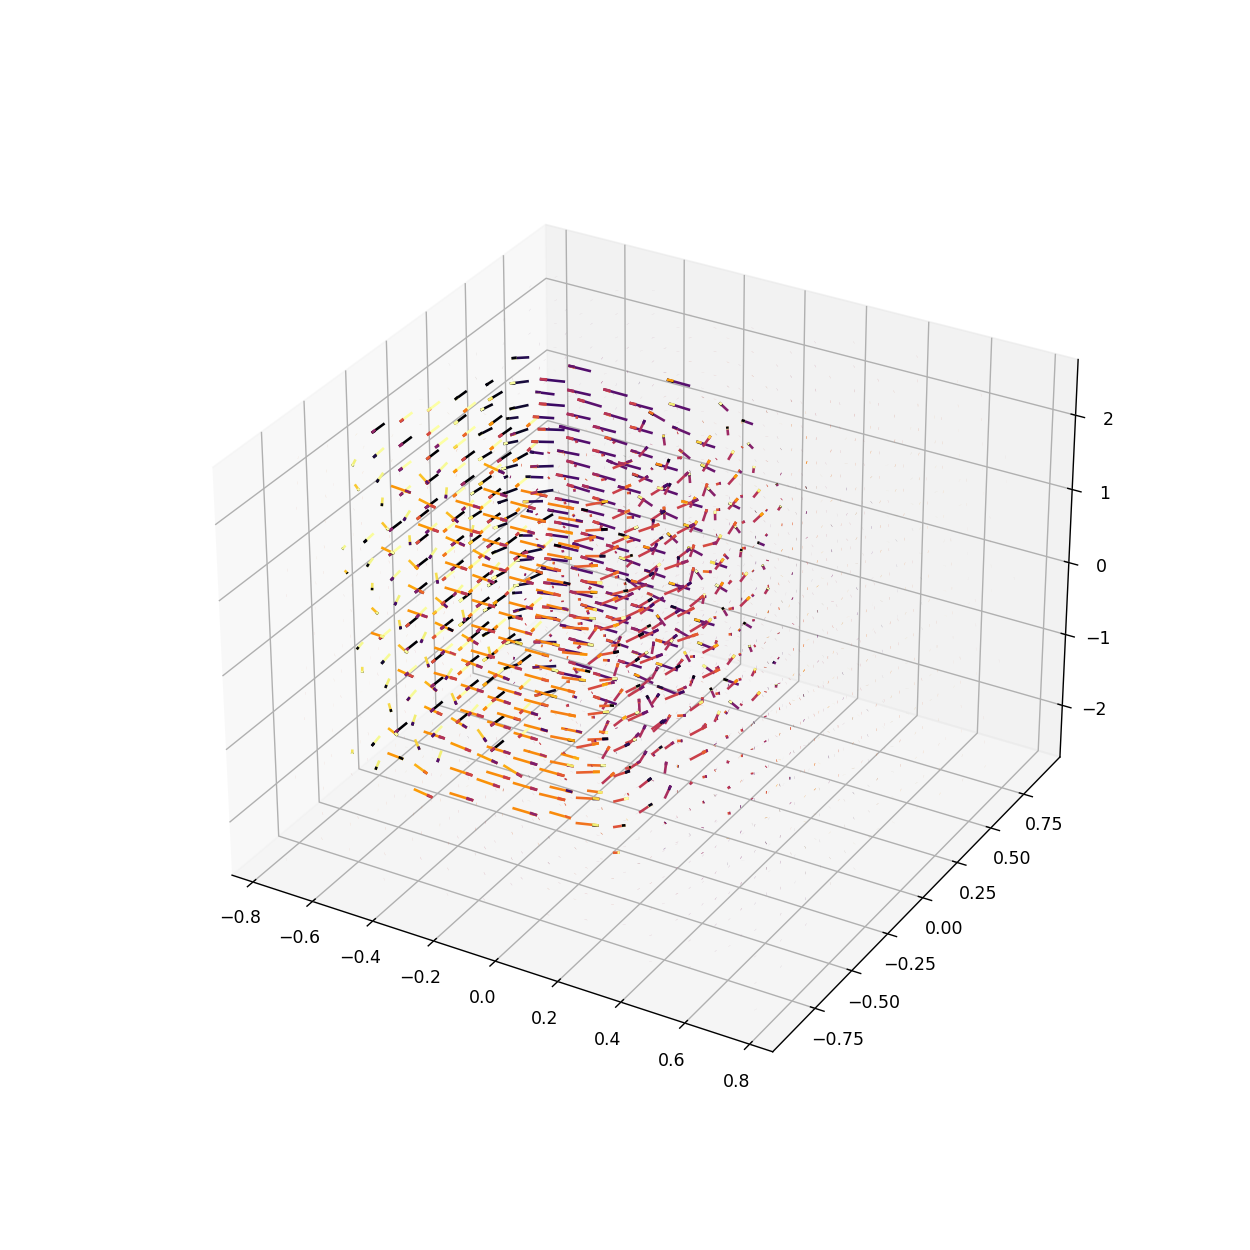

In [39]:
scale=0.05

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.quiver(fieldmapsmall["x"], fieldmapsmall["y"], fieldmapsmall["z"],
          scale*fieldmapsmall["Bx"], scale*fieldmapsmall["By"], scale*fieldmapsmall["Bz"],
         colors=colormap(norm(colors)))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()